In [22]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
titanicDf = pd.read_csv('titanic_train.csv')
titanicDf.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [3]:
titanicDf.shape

(891, 12)

Our dataset has a total of 891 rows and 12 columns

In [4]:
titanicDf.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

There are 177, 687 and 2 missing entries in the columns 'Age', 'Cabin' and 'Embarked', respectively.

Since there are only 891 rows out of which 687 entries are missing in the column 'Cabin' therefore replacing with any values (like mean, median or mode) will not be meaningful. Also imputing a value will also be unreasonable as imputated values are calculated with existing values but since so many entries are missing, imputation is unlikely to produce any useful results. Therefore, we will drop this column entirely.
<p>
    We will also drop the columns 'Name', 'Ticket' and 'PassengerId' as they will not contribute any useful information in the prediction model.
</p>

In [3]:
titanicDf.drop(['Cabin', 'Name', 'PassengerId', 'Ticket'], axis=1, inplace=True)

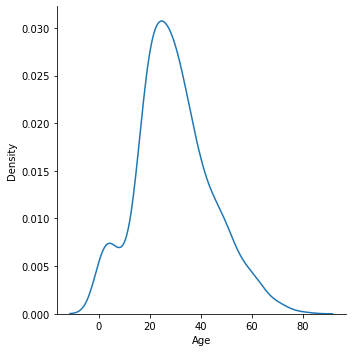

In [6]:
#Checking the distribution of the age column
sns.displot(titanicDf['Age'], kind = 'kde')

Since age is more or less normally distributed, we will replace the missing values with the mean age.

In [4]:
titanicDf['Age'].fillna(titanicDf['Age'].mean(), inplace = True)

Now, since the column is a categorical column, we will replace the two missing values with the mode of the column.

In [5]:
#Finding the most frequently occuring category in the 'Embarked' column
titanicDf['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [6]:
titanicDf['Embarked'].fillna('S', inplace = True)

In [7]:
titanicDf.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

After all the necessary steps done on the last few cells, our dataset is now free of any missing values.

In [8]:
#checking summary statistics
titanicDf.describe()

Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   13.002015    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   22.000000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   29.699118    0.000000    0.000000   14.454200
75%      1.000000    3.000000   35.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

In [12]:
titanicDf.groupby('Survived')['Pclass'].value_counts()

Survived  Pclass
0         3         372
          2          97
          1          80
1         1         136
          3         119
          2          87
Name: Pclass, dtype: int64

From the above, we see that there are most passengers who died were travelling on a 3rd Class ticket while the highest number of passengers in the 1st Class survived more then any other class.

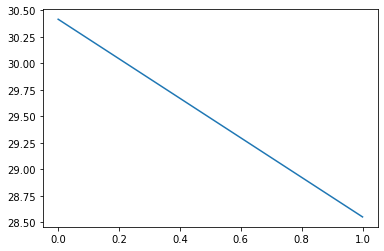

In [13]:
plt.plot(titanicDf.groupby('Survived')['Age'].mean())

The average age of those who died was arounf 30.40 years while those who survived was around 28.60.

In [14]:
titanicDf.groupby('Survived')['Embarked'].value_counts()

Survived  Embarked
0         S           427
          C            75
          Q            47
1         S           219
          C            93
          Q            30
Name: Embarked, dtype: int64

Most people who died as well as survived in the Titanic embraked from 'S' which stands for Southampton.

In [9]:
titanicDf.groupby('Survived')['Sex'].value_counts()

Survived  Sex   
0         male      468
          female     81
1         female    233
          male      109
Name: Sex, dtype: int64

In case of passengers who died, most of them were male and amongs those who survived, most were female.

We will try to visualise the result of above four cells

<AxesSubplot:xlabel='Survived', ylabel='count'>

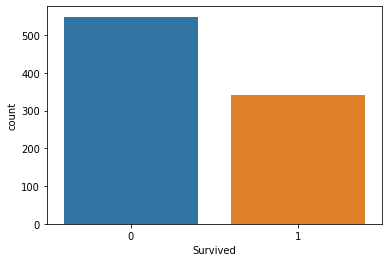

In [16]:
sns.countplot('Survived', data = titanicDf)

The column 'Survived' is our target variable and from the above visual we can see that there are more then 550 passengers who died ehile around 350 passengers who survived. Therefore, this is an imbalanced dataset and needs to be balanced before model building.

<AxesSubplot:xlabel='Pclass', ylabel='count'>

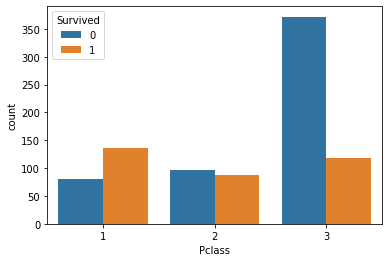

In [17]:
sns.countplot('Pclass', data = titanicDf, hue='Survived')

Most Passenger who died are from class 3 while most who survived are from class 1.

<AxesSubplot:xlabel='Sex', ylabel='count'>

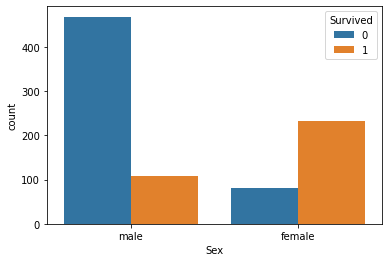

In [18]:
sns.countplot('Sex', data = titanicDf, hue='Survived')

In case of passengers who died, most were male and those who survived were female.

<AxesSubplot:>

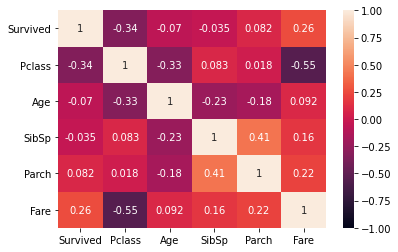

In [19]:
sns.heatmap(titanicDf.corr(), vmax = 1, vmin = -1, annot =True)

We see that the all the numeric columns have very less correlation coefficient with the target variable.

In [10]:
#Splitting the feature and the target columns
x = titanicDf.drop('Survived', axis = 1)
y = titanicDf.Survived

In [11]:
x.skew()

Pclass   -0.630548
Age       0.434488
SibSp     3.695352
Parch     2.749117
Fare      4.787317
dtype: float64

In [12]:
x['SibSp'] = (x['SibSp'])**(1/3)
x['Parch'] = (x['Parch'])**(1/3)
x['Fare'] = (x['Fare'])**(1/3)

In [13]:
x.skew()

Pclass   -0.630548
Age       0.434488
SibSp     1.033059
Parch     1.348334
Fare      1.230382
dtype: float64

Having done the required transformation, we see that the skewness have reduced. However, this is the lowest possible reduction we could achieve using all the techniques.

In [15]:
#Scaling the numeric columns
numericData = x.drop(['Sex', 'Pclass', 'Embarked'], axis=1)
scaler = MinMaxScaler()
scaler.fit(numericData)

MinMaxScaler()

In [17]:
x[['Age_transformed','SibS_transformed','Parch_transformed', 'Fare_transformed']] = scaler.transform(numericData)

In [28]:
x

Pclass     Sex        Age  SibSp     Parch      Fare Embarked  \
0         3    male  22.000000    1.0  0.000000  1.935438        S   
1         1  female  38.000000    1.0  0.000000  4.146318        C   
2         3  female  26.000000    0.0  0.000000  1.993730        S   
3         1  female  35.000000    1.0  0.000000  3.758647        S   
4         3    male  35.000000    0.0  0.000000  2.004158        S   
..      ...     ...        ...    ...       ...       ...      ...   
886       2    male  27.000000    0.0  0.000000  2.351335        S   
887       1  female  19.000000    0.0  0.000000  3.107233        S   
888       3  female  29.699118    1.0  1.259921  2.862294        S   
889       1    male  26.000000    0.0  0.000000  3.107233        C   
890       3    male  32.000000    0.0  0.000000  1.978946        Q   

     Age_transformed  SibS_transformed  Parch_transformed  Fare_transformed  
0           0.271174               0.5           0.000000          0.241878  
1           0.472229               0.5           0.000000          0.518179  
2           0.321438               0.0           0.000000          0.249163  
3           0.434531               0.5           0.000000          0.469730  
4           0.434531               0.0           0.000000          0.250466  
..               ...               ...                ...               ...  
886         0.334004               0.0           0.000000          0.293854  
887         0.233476               0.0           0.000000          0.388321  
888         0.367921               0.5           0.693361          0.357710  
889         0.321438               0.0           0.000000          0.388321  
890         0.396833               0.0           0.000000          0.247315  

[891 rows x 11 columns]

In [19]:
#One-hot encoding all the categorical columns
x = pd.get_dummies(x, columns=['Sex', 'Pclass', 'Embarked'])

In [20]:
x.drop(numericData.columns, axis = 1, inplace=True)

In [21]:
x

Age_transformed  SibS_transformed  Parch_transformed  Fare_transformed  \
0           0.271174               0.5           0.000000          0.241878   
1           0.472229               0.5           0.000000          0.518179   
2           0.321438               0.0           0.000000          0.249163   
3           0.434531               0.5           0.000000          0.469730   
4           0.434531               0.0           0.000000          0.250466   
..               ...               ...                ...               ...   
886         0.334004               0.0           0.000000          0.293854   
887         0.233476               0.0           0.000000          0.388321   
888         0.367921               0.5           0.693361          0.357710   
889         0.321438               0.0           0.000000          0.388321   
890         0.396833               0.0           0.000000          0.247315   

     Sex_female  Sex_male  Pclass_1  Pclass_2  Pclass_3  Embarked_C  \
0             0         1         0         0         1           0   
1             1         0         1         0         0           1   
2             1         0         0         0         1           0   
3             1         0         1         0         0           0   
4             0         1         0         0         1           0   
..          ...       ...       ...       ...       ...         ...   
886           0         1         0         1         0           0   
887           1         0         1         0         0           0   
888           1         0         0         0         1           0   
889           0         1         1         0         0           1   
890           0         1         0         0         1           0   

     Embarked_Q  Embarked_S  
0             0           1  
1             0           0  
2             0           1  
3             0           1  
4             0           1  
..          ...         ...  
886           0           1  
887           0           1  
888           0           1  
889           0           0  
890           1           0  

[891 rows x 12 columns]

In [39]:
#Finding the best random state
maxAcc = 0
maxRs = 0
for randState in range(0,200):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=randState)
    lr = LogisticRegression()
    lr.fit(x_train, y_train)
    predlr = lr.predict(x_test)
    acc = accuracy_score(y_test, predlr)
    if acc>maxAcc:
        maxAcc=acc
        maxRs=randState
print(f"Best accuracy is {maxAcc*100}% on Random state {randState}")

Best accuracy is 84.70149253731343% on Random state 199


In [42]:
 x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=199)

In [43]:
#Balancing the dataset using oversampling
oversampler = RandomOverSampler()
x_train_new, y_train_new = oversampler.fit_resample(x_train, y_train)

In [51]:
#Fitting all the algorithms and printing thier evaluation matrics
models = [RandomForestClassifier(), AdaBoostClassifier(), SVC(), LogisticRegression()]

for model in models:
    model.fit(x_train_new, y_train_new)
    pred = model.predict(x_test)
    print(f'\nAccuracy metrics of {model}:\n \nAccuracy Score: {accuracy_score(y_test, pred)}\n')
    print(f'\nClassification Report:\n {classification_report(y_test, pred)}\n')
    print(f'Confusion Matrix:\n{confusion_matrix(y_test, pred)}\nF1-Score: {f1_score(y_test, pred)}')


Accuracy metrics of RandomForestClassifier():
 
Accuracy Score: 0.7574626865671642


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.82      0.81       164
           1       0.70      0.65      0.68       104

    accuracy                           0.76       268
   macro avg       0.75      0.74      0.74       268
weighted avg       0.76      0.76      0.76       268


Confusion Matrix:
[[135  29]
 [ 36  68]]
F1-Score: 0.6766169154228855

Accuracy metrics of AdaBoostClassifier():
 
Accuracy Score: 0.7798507462686567


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.82       164
           1       0.71      0.74      0.72       104

    accuracy                           0.78       268
   macro avg       0.77      0.77      0.77       268
weighted avg       0.78      0.78      0.78       268


Confusion Matrix:
[[132  32]
 [ 27  77]]
F1-Score: 0.72300

###### Cross Validation

In [57]:
cvLr = cross_val_score(LogisticRegression(), x_train_new, y_train_new, scoring='f1', cv = 5)
print(f'Cross-validation F1-score: {cvLr.mean()}')
print(f'Difference: {0.712962962962963-cvLr.mean()}')

Cross-validation F1-score: 0.7861728634308551
Difference: -0.07320990046789211


In [59]:
cvSVC = cross_val_score(SVC(), x_train_new, y_train_new, scoring='f1', cv = 5)
print(f'Cross-validation F1-score: {cvSVC.mean()}')
print(f'Difference: {0.7686567164179104-cvSVC.mean()}')

Cross-validation F1-score: 0.7871069405996686
Difference: -0.018450224181758124


In [60]:
cvRfc = cross_val_score(RandomForestClassifier(), x_train_new, y_train_new, scoring='f1', cv = 5)
print(f'Cross-validation F1-score: {cvRfc.mean()}')
print(f'Difference: {0.6766169154228855-cvRfc.mean()}')

Cross-validation F1-score: 0.866043273806987
Difference: -0.1894263583841015


In [61]:
cvAb = cross_val_score(AdaBoostClassifier(), x_train_new, y_train_new, scoring='f1', cv = 5)
print(f'Cross-validation F1-score: {cvAb.mean()}')
print(f'Difference: {0.7230046948356808-cvAb.mean()}')

Cross-validation F1-score: 0.8013683294248775
Difference: -0.0783636345891967


We choose RandomForest as our final algorithm since it has the least difference

###### Hyper parameter tuning

In [62]:
parameters = {'n_estimators':[10,50,150,100,200,250,500,1000,1500],
             'criterion': ['gini', 'entropy'],
             'max_features': ['auto', 'sqrt', 'log2'],
             'bootstrap': ['True', 'False']}

In [76]:
gs = GridSearchCV(RandomForestClassifier(), cv = 5, param_grid = parameters, n_jobs = -1, scoring='f1')

In [77]:
gs.fit(x_train_new, y_train_new)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': ['True', 'False'],
                         'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 50, 150, 100, 200, 250, 500, 1000,
                                          1500]},
             scoring='f1')

In [78]:
gs.best_params_

{'bootstrap': 'True',
 'criterion': 'entropy',
 'max_features': 'log2',
 'n_estimators': 100}

In [83]:
gs.best_score_

0.8736893599470287

In [84]:
pred = gs.predict(x_test)

In [85]:
print(f'\nAccuracy metrics of RFC:\n \nAccuracy Score: {accuracy_score(y_test, pred)}\n')
print(f'\nClassification Report:\n {classification_report(y_test, pred)}\n')
print(f'Confusion Matrix:\n{confusion_matrix(y_test, pred)}\nF1-Score: {f1_score(y_test, pred)}')


Accuracy metrics of RFC:
 
Accuracy Score: 0.7761194029850746


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82       164
           1       0.72      0.69      0.71       104

    accuracy                           0.78       268
   macro avg       0.76      0.76      0.76       268
weighted avg       0.77      0.78      0.78       268


Confusion Matrix:
[[136  28]
 [ 32  72]]
F1-Score: 0.7058823529411765


###### saving the final model

In [86]:
rfc = RandomForestClassifier(bootstrap = True, criterion = 'entropy',max_features = 'log2',n_estimators= 100)
rfc.fit(x_train_new, y_train_new)
joblib.dump(rfc, 'titanic.pkl')

['titanic.pkl']

In [88]:
model = joblib.load('titanic.pkl')
pred = model.predict(x_test)
pred

array([1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0], dtype=int64)